In [1]:
import numpy as np
import re

In [2]:
# File processing Lowercase + punctuation removal
book = 'War_and_Peace.txt'
file = open(book, 'r', encoding='utf-8')
text = file.read()
file.close()

text = re.sub(r'[^a-zA-Z]', " ", text)
text = " ".join(text.split()).lower()[:100000]

In [3]:
# Store unique characters
dictionary = {}
for i in range(26):
    dictionary[chr(i + 97)] = i
dictionary[" "] = 26

In [4]:
# Initialization

# Observed sequence
O = np.zeros(len(text), dtype=int)

for i in range(len(text)):
    O[i] = dictionary[text[i]]

# Initial State
pi = np.array(([0.55, 0.45]))
# Observable sequence
B = np.array([[0.03735, 0.03408, 0.03455, 0.03828, 0.03782, 0.03922, 0.03688, 0.03408, 0.03875, 0.04062, 0.03735, 0.03968, 0.03548, 0.03735, 0.04062, 0.03595, 0.03641, 0.03408, 0.04062, 0.03548, 0.03922, 0.04062, 0.03455, 0.03595, 0.03408, 0.03408, 0.03688],
              [0.03909, 0.03537,  0.03537, 0.03909, 0.03583,  0.03630, 0.04048, 0.03537, 0.03816, 0.03909, 0.03490, 0.03723, 0.03537, 0.03909, 0.03397, 0.03397, 0.03816, 0.03676, 0.04048, 0.03443, 0.03537, 0.03955, 0.03816,  0.03723,  0.03769, 0.03955, 0.03397]])

# Transition matrix
A = np.array([[0.47468, 0.52532], [0.51656, 0.48344]])

# Set of possible observations
V = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '])

# Set of possible states, Q is hidden
# Number of observation symbols
M = len(V)

# Number of states in the model
N = len(A)

# Length of observation sequence
T = len(O)

In [5]:
'''
Alpha Pass
'''
def alpha_pass(A1, B1, pi1, O1):
    c1 = np.zeros([T, 1])
    alpha1 = np.zeros([T, N])
    c1[0][0] = 0
    for x in range(N):
        alpha1[0][x] = pi1[x] * B1[x][O1[0]]
        c1[0][0] = c1[0][0] + alpha1[0][x]
    c1[0][0] = 1/c1[0][0]
    for x in range(N):
        alpha1[0][x] = c1[0][0] * alpha1[0][x]

    for t in range(1, T):
        c1[t][0] = 0
        for x in range(N):
            alpha1[t][x] = 0
            for y in range(N):
                alpha1[t][x] = alpha1[t][x] + alpha1[t-1][y] * A1[y][x]
            alpha1[t][x] = alpha1[t][x] * B1[x][O1[t]]
            c1[t][0] = c1[t][0] + alpha1[t][x]
        c1[t][0] = 1/c1[t][0]
        for x in range(N):
            alpha1[t][x] = c1[t][0] * alpha1[t][x]
    return alpha1, c1

In [6]:
'''
Beta Pass
'''
def beta_pass(A1, B1, O1, c1):
    beta1 = np.zeros([T, N])
    for x in range(N):
        beta1[T-1][x] = c1[T-1][0]
    for t in range(T-2, -1, -1):
        for x in range(N):
            beta1[t][x] = 0
            for y in range(N):
                beta1[t][x] = beta1[t][x] + A1[x][y] * B1[y][O1[t + 1]] * beta1[t + 1][y]
            beta1[t][x] = c1[t][0] * beta1[t][x]
    return beta1

In [7]:
'''
Gamma Pass
'''
def gamma_pass(alpha1, beta1, A1, B1, O1):
    gamma1 = np.zeros([T, N])
    di_gamma1 = np.zeros([T, N, N])
    for t in range(T-1):
        for x in range(N):
            gamma1[t][x] = 0
            for y in range(N):
                di_gamma1[t][x][y] = alpha1[t][x] * A1[x][y] * B1[y][O1[t + 1]] * beta1[t + 1][y]
                gamma1[t][x] = gamma1[t][x] + di_gamma1[t][x][y]
    for x in range(N):
        gamma1[T-1][x] = alpha1[T-1][x]
    return gamma1, di_gamma1

In [8]:
def re_estimate(gamma1, di_gamma1, A1, B1, pi1):
    for x in range(N):
        pi1[x] = gamma1[0][x]
    for x in range(N):
        denominator = 0
        for t in range(T-1):
            denominator = denominator + gamma1[t][x]
        for y in range(N):
            numerator = 0
            for t in range(T-1):
                numerator = numerator + di_gamma1[t][x][y]
            A1[x][y] = numerator/denominator
    for x in range(N):
        denominator = 0
        for t in range(T):
            denominator = denominator + gamma1[t][x]
        for y in range(M):
            numerator = 0
            for t in range(T):
                if O[t] == y:
                    numerator = numerator + gamma1[t][x]
            B1[x][y] = numerator/denominator
    return A1, B1, pi1

In [9]:
'''
Log Probability
'''
def log_prob(c1):
    logProb1 = 0
    for x in range(T):
        logProb1 = logProb1 + np.log(c1[x][0])
    logProb1 = -logProb1
    return logProb1

In [10]:
# INITIAL
oldLogProb = -10000000
print("A: \n", A)
print("B: \n", np.concatenate((V.reshape(1, M), B), axis=0).T)
print("pi: ", pi)
print("logProb: ", oldLogProb)

A: 
 [[0.47468 0.52532]
 [0.51656 0.48344]]
B: 
 [['a' '0.03735' '0.03909']
 ['b' '0.03408' '0.03537']
 ['c' '0.03455' '0.03537']
 ['d' '0.03828' '0.03909']
 ['e' '0.03782' '0.03583']
 ['f' '0.03922' '0.0363']
 ['g' '0.03688' '0.04048']
 ['h' '0.03408' '0.03537']
 ['i' '0.03875' '0.03816']
 ['j' '0.04062' '0.03909']
 ['k' '0.03735' '0.0349']
 ['l' '0.03968' '0.03723']
 ['m' '0.03548' '0.03537']
 ['n' '0.03735' '0.03909']
 ['o' '0.04062' '0.03397']
 ['p' '0.03595' '0.03397']
 ['q' '0.03641' '0.03816']
 ['r' '0.03408' '0.03676']
 ['s' '0.04062' '0.04048']
 ['t' '0.03548' '0.03443']
 ['u' '0.03922' '0.03537']
 ['v' '0.04062' '0.03955']
 ['w' '0.03455' '0.03816']
 ['x' '0.03595' '0.03723']
 ['y' '0.03408' '0.03769']
 ['z' '0.03408' '0.03955']
 [' ' '0.03688' '0.03397']]
pi:  [0.55 0.45]
logProb:  -10000000


In [11]:
# First Iteration

alpha, c = alpha_pass(A, B, pi, O)
beta = beta_pass(A, B, O, c)
gamma, di_gamma = gamma_pass(alpha, beta, A, B, O)
A, B, pi = re_estimate(gamma, di_gamma, A, B, pi)
logProb = log_prob(c)

print("A: \n", A)
print("B: \n", np.concatenate((V.reshape(1, M), np.round_(B, decimals=7)), axis=0).T)
print("pi: ", np.round_(pi, decimals=7))
print("logProb: ", logProb)

A: 
 [[0.48026893 0.51973107]
 [0.52229628 0.47770372]]
B: 
 [['a' '0.0650332' '0.0696181']
 ['b' '0.0103124' '0.0109893']
 ['c' '0.0214131' '0.0224695']
 ['d' '0.0345775' '0.0362066']
 ['e' '0.1003477' '0.0971645']
 ['f' '0.0150525' '0.0143257']
 ['g' '0.0155683' '0.0174965']
 ['h' '0.0509223' '0.0541457']
 ['i' '0.0620849' '0.0625161']
 ['j' '0.0007938' '0.0007862']
 ['k' '0.0067203' '0.006439']
 ['l' '0.0327946' '0.0315424']
 ['m' '0.0185224' '0.0189587']
 ['n' '0.0554752' '0.0594546']
 ['o' '0.0629979' '0.0539197']
 ['p' '0.0194886' '0.0188699']
 ['q' '0.0005581' '0.000602']
 ['r' '0.0461758' '0.0510963']
 ['s' '0.0488063' '0.0498764']
 ['t' '0.0695093' '0.0691498']
 ['u' '0.021594' '0.019962']
 ['v' '0.0114156' '0.0114044']
 ['w' '0.0167512' '0.0189944']
 ['x' '0.004376' '0.0046447']
 ['y' '0.0144712' '0.0164336']
 ['z' '0.000347' '0.0004132']
 [' ' '0.193891' '0.182521']]
pi:  [0.5578291 0.4421709]
logProb:  -330338.22058958607


<BarContainer object of 27 artists>

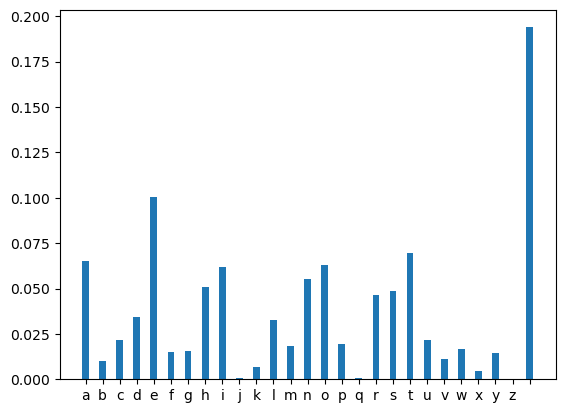

In [12]:
import matplotlib.pyplot as plt
PLOT = np.concatenate((V.reshape(1, M), np.round_(B, decimals=7)), axis=0).T
plt.bar(PLOT[:, 0], PLOT[:, 1].astype(float), width = 0.4)

<BarContainer object of 27 artists>

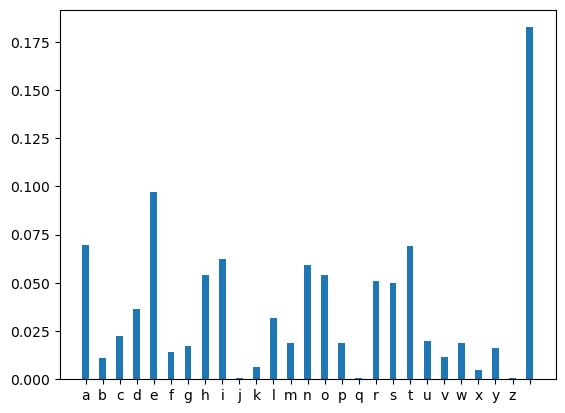

In [13]:
import matplotlib.pyplot as plt
PLOT = np.concatenate((V.reshape(1, M), np.round_(B, decimals=7)), axis=0).T
plt.bar(PLOT[:, 0], PLOT[:, 2].astype(float), width = 0.4)

In [14]:
# Final Output
maxIter = 10
for ite in range(maxIter):
    alpha, c = alpha_pass(A, B, pi, O)
    beta = beta_pass(A, B, O, c)
    gamma, di_gamma = gamma_pass(alpha, beta, A, B, O)
    A, B, pi = re_estimate(gamma, di_gamma, A, B, pi)
    logProb = log_prob(c)

print("A: \n", A)
print("B: \n", np.concatenate((V.reshape(1, M), np.round_(B, decimals=7)), axis=0).T)
print("pi: ", np.round_(pi, decimals=5))
print("logProb: ", logProb)

A: 
 [[0.47900156 0.52099844]
 [0.5235696  0.4764304 ]]
B: 
 [['a' '0.0654623' '0.0691868']
 ['b' '0.0101386' '0.011164']
 ['c' '0.0212549' '0.0226285']
 ['d' '0.0342151' '0.0365707']
 ['e' '0.1014223' '0.0960845']
 ['f' '0.0147046' '0.0146754']
 ['g' '0.0155415' '0.0175234']
 ['h' '0.0506997' '0.0543693']
 ['i' '0.0626198' '0.0619786']
 ['j' '0.000772' '0.0008081']
 ['k' '0.0066588' '0.0065008']
 ['l' '0.0325864' '0.0317515']
 ['m' '0.018213' '0.0192696']
 ['n' '0.0553697' '0.0595606']
 ['o' '0.0632704' '0.0536459']
 ['p' '0.0193989' '0.0189601']
 ['q' '0.0005421' '0.0006181']
 ['r' '0.0456102' '0.0516647']
 ['s' '0.0483333' '0.0503517']
 ['t' '0.0689676' '0.0696942']
 ['u' '0.0215088' '0.0200476']
 ['v' '0.0112578' '0.011563']
 ['w' '0.0164531' '0.0192939']
 ['x' '0.0043461' '0.0046747']
 ['y' '0.0142245' '0.0166816']
 ['z' '0.0003419' '0.0004183']
 [' ' '0.1960868' '0.1803144']]
pi:  [0.56173 0.43827]
logProb:  -284243.9542204271


<BarContainer object of 27 artists>

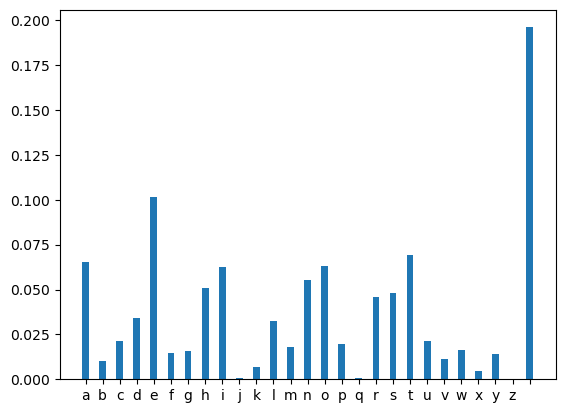

In [15]:
import matplotlib.pyplot as plt
PLOT = np.concatenate((V.reshape(1, M), np.round_(B, decimals=7)), axis=0).T

plt.bar(PLOT[:, 0], PLOT[:, 1].astype(float), width = 0.4)